In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightkurve as lk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# --- 1. Advanced Data Simulation ---
def generate_synthetic_light_curve(time, is_exoplanet=False, period=None):
    """
    Generates a more realistic synthetic light curve with optional transit.
    """
    flux = np.random.normal(loc=1.0, scale=0.001, size=len(time))
    flux += 0.005 * np.sin(time / np.random.uniform(20, 80)) # Stellar variability

    if is_exoplanet:
        if period is None:
            period = np.random.uniform(5, 50)
        transit_duration = period * np.random.uniform(0.02, 0.08)
        transit_depth = np.random.uniform(0.003, 0.02)
        
        # Use a more realistic U-shaped transit
        phase = (time % period) / period
        in_transit = phase < (transit_duration / period)
        transit_phase = (phase[in_transit] / (transit_duration / period)) * np.pi
        flux[in_transit] -= transit_depth * (1 - (np.sin(transit_phase - np.pi/2)**2))

    return lk.LightCurve(time=time, flux=flux)

# Generate a time array
time_base = np.arange(0, 120, 0.02)

num_exoplanets = 150
num_non_exoplanets = 500
light_curves = []
labels = []

print("Generating synthetic light curves...")
for _ in range(num_exoplanets):
    light_curves.append(generate_synthetic_light_curve(time_base, is_exoplanet=True))
    labels.append(1)

for _ in range(num_non_exoplanets):
    light_curves.append(generate_synthetic_light_curve(time_base, is_exoplanet=False))
    labels.append(0)

print(f"Generated {len(light_curves)} light curves.")

/opt/homebrew/Caskroom/miniforge/base/envs/tf-macos/lib/python3.9/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


Generating synthetic light curves...
Generated 650 light curves.
Generated 650 light curves.


In [3]:

# --- 2. Advanced Preprocessing & Feature Engineering ---
def advanced_feature_engineering(lc):
    """
    Performs robust preprocessing and extracts a rich set of features.
    """
    lc = lc.remove_nans().remove_outliers(sigma=5)
    
    # Use lightkurve's flatten method for robust detrending
    flattened_lc = lc.flatten(window_length=401)
    
    # Periodogram analysis to find the most likely period
    periodogram = flattened_lc.to_periodogram(method='bls', minimum_period=1, maximum_period=50)
    best_fit_period = periodogram.period_at_max_power
    
    # Fold the light curve on the best period
    folded_lc = flattened_lc.fold(period=best_fit_period)
    
    # Bin the folded light curve to create a consistent shape vector
    binned_lc = folded_lc.bin(time_bin_size=0.01)
    # Normalize and handle potential length differences by padding/truncating
    folded_flux = binned_lc.flux.value
    folded_flux = (folded_flux - np.mean(folded_flux)) / (np.std(folded_flux) + 1e-6)
    
    fixed_size = 100
    if len(folded_flux) > fixed_size:
        folded_flux = folded_flux[:fixed_size]
    else:
        folded_flux = np.pad(folded_flux, (0, fixed_size - len(folded_flux)), 'constant', constant_values=0)

    # Feature Extraction
    features = {
        # Statistics from the flattened (unfolded) light curve
        'std_dev_flux': np.std(flattened_lc.flux),
        'skewness_flux': pd.Series(flattened_lc.flux).skew(),
        'kurtosis_flux': pd.Series(flattened_lc.flux).kurtosis(),
        'amp': np.ptp(flattened_lc.flux), # Peak-to-peak amplitude
        
        # Features from the periodogram
        'best_period': best_fit_period.value,
        'max_power': periodogram.max_power.value,
        
        # Features from the folded light curve
        'transit_depth_est': np.abs(np.min(folded_lc.flux) - 1.0),
        'transit_duration_est': (folded_lc.time.value < 0.1).sum() / len(folded_lc.time) # Rough duration estimate
    }
    
    # Add the binned folded curve as features
    for i, val in enumerate(folded_flux):
        features[f'folded_bin_{i}'] = val
        
    return pd.Series(features)

# Process all light curves
print("Performing advanced feature engineering...")
all_features = [advanced_feature_engineering(lc) for lc in light_curves]
features_df = pd.DataFrame(all_features).fillna(0)

print("Feature engineering complete.")
print(f"Features DataFrame shape: {features_df.shape}")

Performing advanced feature engineering...
Feature engineering complete.
Features DataFrame shape: (650, 108)
Feature engineering complete.
Features DataFrame shape: (650, 108)


In [4]:
# --- 3. Feature Scaling and Selection ---
X = features_df
y = np.array(labels)

# Split data before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nPerforming feature selection with RandomForest...")
# Use a RandomForestClassifier to select the most important features
feature_selector = RandomForestClassifier(n_estimators=100, random_state=42)
selector = SelectFromModel(feature_selector, threshold='median')

X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X.columns[selector.get_support()]
print(f"Selected {X_train_selected.shape[1]} features out of {X.shape[1]}")
print("Top selected features:", selected_features[:10].tolist(), "...")


# --- 4. Hyperparameter Tuning and Model Comparison ---
print("\nTuning hyperparameters for different classifiers...")

classifiers = {
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_leaf': [1, 2],
        'class_weight': ['balanced']
    }),
    'LogisticRegression': (LogisticRegression(random_state=42, max_iter=1000), {
        'C': [0.1, 1, 10],
        'solver': ['liblinear'],
        'class_weight': ['balanced']
    }),
    'SVC': (SVC(random_state=42, probability=True), {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'class_weight': ['balanced']
    }),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    })
}

best_models = {}
for name, (model, param_grid) in classifiers.items():
    print(f"\n--- Tuning {name} ---")
    grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='roc_auc')
    grid_search.fit(X_train_selected, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best Score (ROC AUC) for {name}: {grid_search.best_score_:.4f}")
    print(f"Best Hyperparameters for {name}: {grid_search.best_params_}")

print("\nModel tuning complete.")


Performing feature selection with RandomForest...
Selected 54 features out of 108
Top selected features: ['std_dev_flux', 'skewness_flux', 'kurtosis_flux', 'amp', 'best_period', 'max_power', 'transit_depth_est', 'transit_duration_est', 'folded_bin_3', 'folded_bin_6'] ...

Tuning hyperparameters for different classifiers...

--- Tuning RandomForest ---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Score (ROC AUC) for RandomForest: 1.0000
Best Hyperparameters for RandomForest: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}

--- Tuning LogisticRegression ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Score (ROC AUC) for LogisticRegression: 1.0000
Best Hyperparameters for LogisticRegression: {'C': 10, 'class_weight': 'balanced', 'solver': 'liblinear'}

--- Tuning SVC ---
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Score (ROC AUC) for SVC: 1.0000
Best Hyperparameters for SVC: {'C': 10, 


--- Evaluation for RandomForest ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000

--- Evaluation for LogisticRegression ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000

--- Evaluation for SVC ---
Accuracy: 0.9939
Precision: 1.0000
Recall: 0.9737
F1-score: 0.9867
ROC AUC: 1.0000

--- Evaluation for GradientBoosting ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC: 1.0000


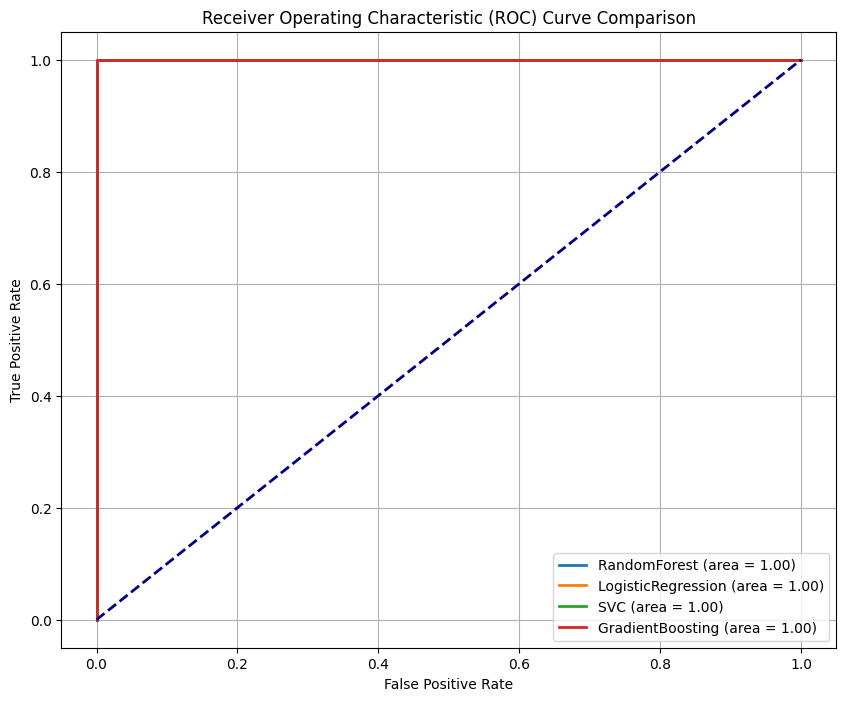


Best performing model: RandomForest with ROC AUC: 1.0000


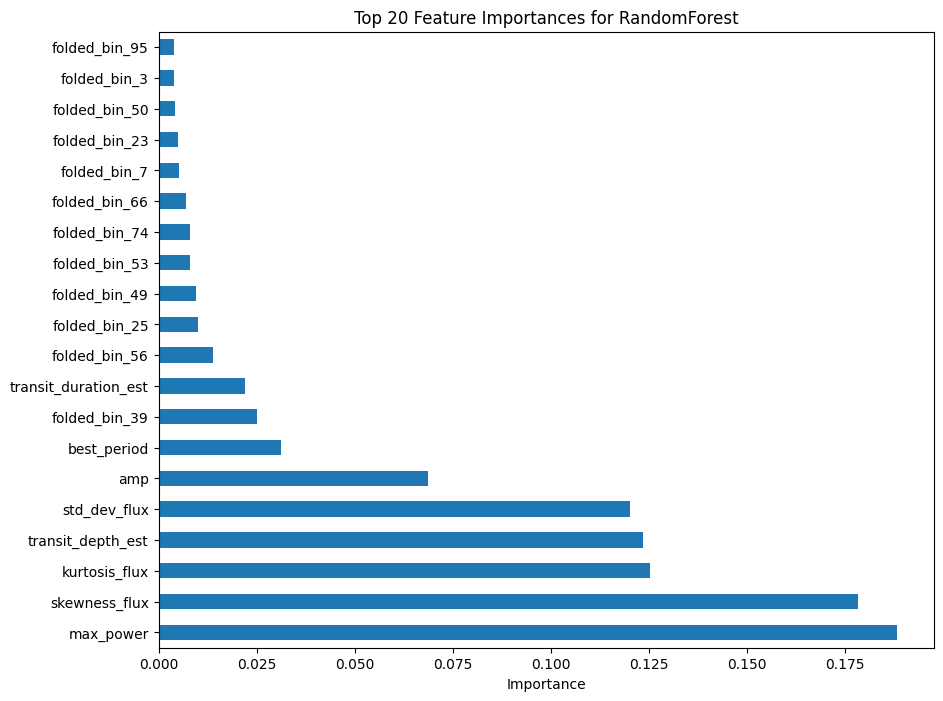

In [5]:
# --- 5. Final Model Evaluation and Comparison ---
plt.figure(figsize=(10, 8))
best_model_name = None
best_roc_auc = 0
best_model = None

for name, model in best_models.items():
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1]
    
    print(f"\n--- Evaluation for {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
    
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"ROC AUC: {roc_auc:.4f}")

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model_name = name
        best_model = model

    # Plot ROC curve for the current model
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nBest performing model: {best_model_name} with ROC AUC: {best_roc_auc:.4f}")

# --- Feature Importance for the Best Model ---
# Check if the best model has the 'feature_importances_' attribute
if hasattr(best_model, 'feature_importances_'):
    feature_importances = pd.Series(best_model.feature_importances_, index=selected_features)
    plt.figure(figsize=(10, 8))
    feature_importances.nlargest(20).plot(kind='barh')
    plt.title(f"Top 20 Feature Importances for {best_model_name}")
    plt.xlabel("Importance")
    plt.show()
else:
    print(f"\nFeature importance is not available for the best model ({best_model_name}).")

In [11]:
# --- 6. Save the Final Model, Scaler, and Selected Features ---
import joblib
import json

# Save the tuned model
joblib.dump(best_model, '/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/exoplanet_model_ML_lightcurve.pkl')

# Save the scaler
joblib.dump(scaler, '/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/scaler_ML_lightcurve.pkl')

# Save the list of selected feature names
with open('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/selected_features_ML_lightcurve.json', 'w') as f:
    json.dump(selected_features.tolist(), f)

print("Final model, scaler, and feature list have been saved.")

Final model, scaler, and feature list have been saved.


In [ ]:
#use test data for final evaluation

